**Modeling Notebook for**

* Train/Test split
* ML Pipeline creation using Logistic Regression
* Performance metrics like confusion matrix, Accuracy / Precision / Recall / F1 will be used.

In [13]:
import pandas as pd

df_to_sample = pd.read_parquet('../Data/feature_engineered_stroke_data.parquet')
df_to_sample.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline  # important!
from imblearn.over_sampling import SMOTE

#define features and target
X = df_to_sample.drop(columns=['stroke'])
y = df_to_sample['stroke']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    )

# Identify columns
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns
categorical_cols = X_train.select_dtypes(include=['object','category']).columns

# Numerical pipeline (Median Impute)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline (Most frequent or constant)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# FULL MODEL PIPELINE INCLUDING SMOTE
model_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42,sampling_strategy=0.7)),
    ('clf', LogisticRegression(max_iter=1000))
])

# Fit
model_pipeline.fit(X_train, y_train)

#precitions
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:,1]


In [27]:
# Applying predictions on test set

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Accuracy: 0.6947162426614482

Confusion Matrix:
 [[675 297]
 [ 15  35]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.69      0.81       972
           1       0.11      0.70      0.18        50

    accuracy                           0.69      1022
   macro avg       0.54      0.70      0.50      1022
weighted avg       0.94      0.69      0.78      1022


ROC AUC Score: 0.7960905349794237


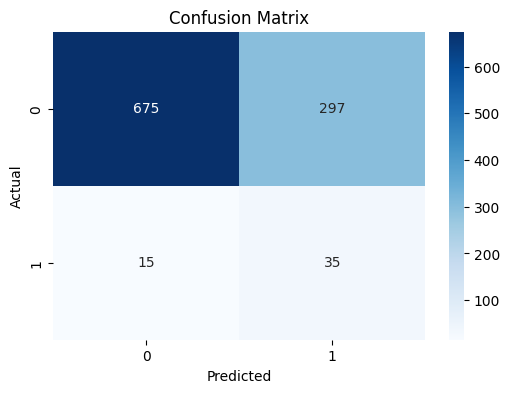

In [16]:
# plotting the performance metrics
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



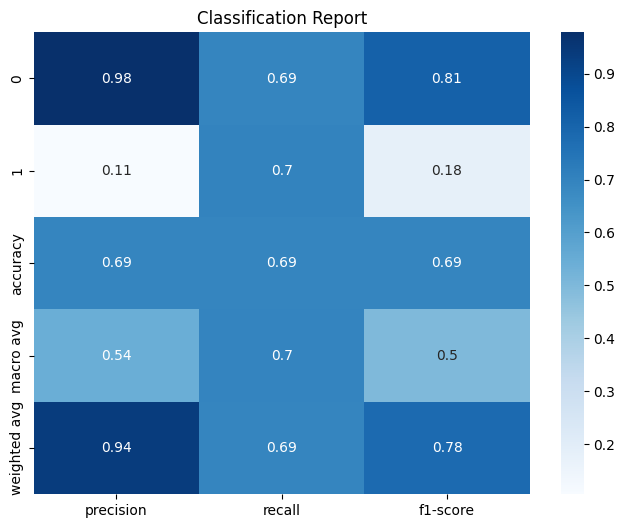

In [20]:
# plot classfication report
report = classification_report(y_test, y_pred, output_dict=True)
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()


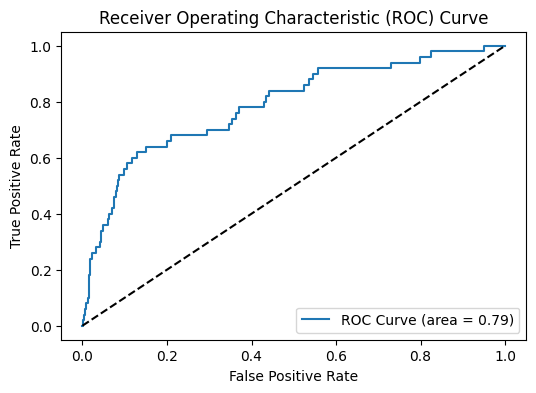

In [29]:
#line plot of roc curve
from pyexpat import model
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, model_pipeline.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc_score(y_test, model_pipeline.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Using a sampling strategy of 1:1 between train and test data samples.**

Logistic regression does not seem powerful enough for this task. The low F1 score (18%) for predicitng strokes is low.

Precision score for 1 is 11%, meaning most predictive strokes are false positives.

**Tuning the minority upsampling does not improve the performance - the test set is small for the minority class (1).**

**It is better to try stronger classifier like Random Forest - which are known to handle small imbalanced datasets better**

In [ ]:
#Reloading the cleaned data
df = pd. read_parquet('../Data/feature_engineered_stroke_data.parquet')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


Accuracy: 0.9481409001956947

Confusion Matrix:
 [[967   5]
 [ 48   2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.29      0.04      0.07        50

    accuracy                           0.95      1022
   macro avg       0.62      0.52      0.52      1022
weighted avg       0.92      0.95      0.93      1022


ROC AUC Score: 0.7771913580246914


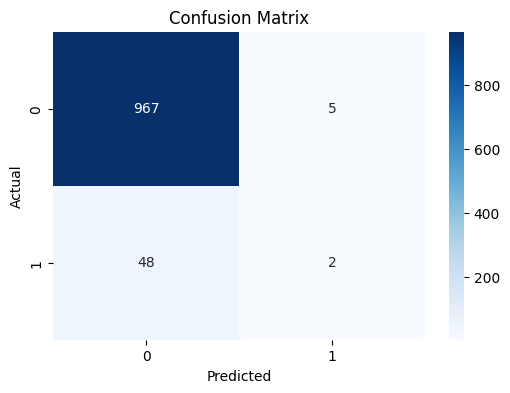

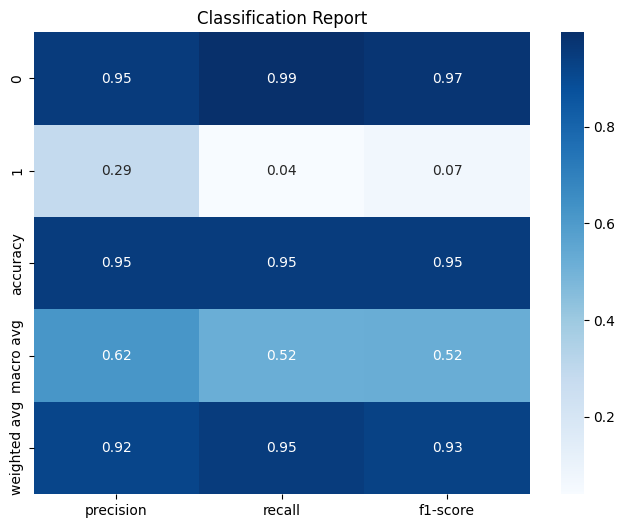

In [34]:
from sklearn.ensemble import RandomForestClassifier as RandomForest


#define features and targets and then train test split
X = df.drop(columns=['stroke'])
y = df['stroke']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    )


# Identify columns
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns
categorical_cols = X_train.select_dtypes(include=['object','category']).columns

# Numerical pipeline (Median Impute)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])  
# Categorical pipeline (Most frequent or constant)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Full Pipeline with SMOTE + Random Forest
rf_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42,sampling_strategy=0.5)),
    ('clf', RandomForest(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
        ))
])

# Fit the model on the training data
rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred = rf_pipeline.predict(X_test)
y_pred_proba = rf_pipeline.predict_proba(X_test)[:,1]

# Applying predictions on test set
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# plotting the performance metrics
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')

plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# plot classfication report
report = classification_report(y_test, y_pred, output_dict=True)
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()
